In [1]:
from __future__ import print_function                                                                                                                                
import sys
import os
import gc
from copy import deepcopy
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as LA
import scipy.sparse as sp
from modules.convert_parameters import get_kp_model, angstrom_par
from modules.kp_model.kp_model import kp_model
import modules.axial_approximation.axial_kane_model as akm
from modules.kp_model.utils import kp_from_sympy, getpath, calcEpath, getdist, sigma
from modules.kp_model.tb_model import tb_model
from modules.wire import wire_factory
from modules.wire import double_Hilbert_space, pairing_term
from IPython.display import display, Math, Latex
import sympy
sympy.init_printing()

In [2]:
## ------------------ wire parameters ----------------------
diameter = 400    # in Angstrom
nlayer = 20       # how many layers form the wire, for discretization
Vd   = 0.12e-3 # electric potential, in eV/Angstrom
Bs   = .5        # scalar value of magnetic field
Bv  = np.array([1.,1.,1.])
Bv /= LA.norm(Bv) # axial direction of the wire
Delta  = 0.2e-3        # superconducting gap
mu     = 39.6e-3       # chemical potential

par = angstrom_par(B=Bs*Bv,gamma_0=5,material='InAs')    
par

{'gamma_1': 5.078668534234156,
 'B_y': 0.28867513459481292,
 'E_v': -0.418,
 m_0: 5.685630060215049e-30,
 'kappa': -0.060665732882921652,
 'gamma_0': 5,
 'P': 8.5557579394993795,
 'epsilon': 15.15,
 'E_0': 0.418,
 'gamma_3': 1.4393342671170783,
 hbar: 6.5821195139999995e-15,
 'B_x': 0.28867513459481292,
 'gamma_2': 0.63933426711707941,
 'Delta': 0.38,
 mu_B: 5.7883818012e-05,
 'g': -0.30825574688967627,
 'B_z': 0.28867513459481292}

In [3]:
## ------------------- kp model -------------------                                                                                                                  
kp = get_kp_model(par=par,convert_basis=True) # use now the s,p basis
kp.h[(0,0,0)] -= mu*np.eye(kp.N)

In [4]:
## ------------------- make wire -----------------                                                                                                                   
ex, ey, center, wire_kpd = wire_factory(kp, diameter, nlayer, shape='hexagonal')

## add electromagnetic potential
Av = np.cross(Bs*Bv, ey)
vector_potential = lambda pos: Av*(np.dot(ey, pos) - np.dot(ey, center))
Ev = ex
scalar_potential = lambda pos: Vd*(np.dot(pos,Ev)-np.dot(center,Ev))
wire_kpd.add_vector_potential(vector_potential)
wire_kpd.add_scalar_potential(scalar_potential)

S_op = sp.kron(sp.eye(wire_kpd.norb//kp.N),
               Bv[0]*sp.kron(sigma.x,sp.eye(4))+
               Bv[1]*sp.kron(sigma.y,sp.eye(4))+
               Bv[2]*sp.kron(sigma.z,sp.eye(4)))


7/8


In [5]:
##  -------------------- solve wire  --------------------                                                                                                     
nsparse = min(20,wire_kpd.norb-2)
E,V  = sp.linalg.eigsh(sp.csc_matrix(wire_kpd.H([0,0,0],sparse=True)),k=nsparse,tol=1e-6,sigma=-mu)
gc.collect()

log = E > -mu
E = E[log]
V = V[:,log]
ind = np.argsort(E)
E = E[ind]
V = V[:,ind]
S = np.diag(np.dot(V.T.conj(), S_op.dot(V))).real
gfactors = np.sign(np.diff(S)[:12:2])*np.diff(E)[:12:2]/LA.norm(Bs)/5.788382e-5

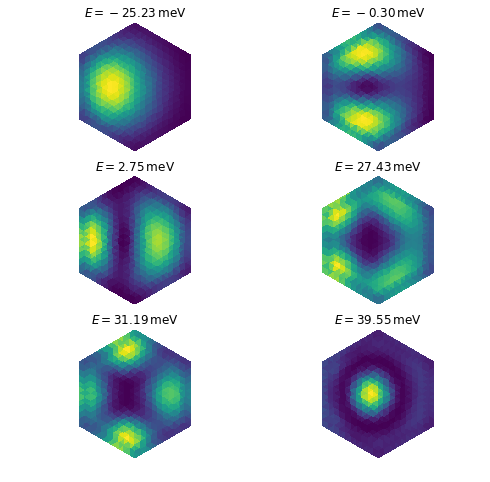

In [6]:
##  -------------------- plot wavefunction  --------------------  
fig, axes = plt.subplots(figsize=(8,8),nrows=3,ncols=2, sharey=True,sharex=True)
x,y = np.array([np.dot(ex,pos) for pos in wire_kpd.lat.p]),np.array([np.dot(ey,pos) for pos in wire_kpd.lat.p])

for i,nE in enumerate(range(0,12,2)):
    z = np.abs(V[:,nE])**2                                                                                                    
    # make elements unique                                                                                                                                           
    unique_weights = {}
    for xi,yi,zi in zip(x,y,z):
        xi = np.round(xi,8)
        yi = np.round(yi,8)
        try:
            unique_weights[(xi,yi)] += zi
        except:
            unique_weights.update({(xi,yi) : zi})
    pos = []
    weights = []
    for key, value in unique_weights.items():
        pos.append(key)
        weights.append(value)
    pos     = np.array(pos)
    weights = np.array(weights)

    ax = axes[nE//4,(nE//2)%2]
    c = ax.tripcolor(pos[:,0],pos[:,1],weights)
    c.set_rasterized(True)
    ax.axis('equal')
    ax.set_xlim([np.min(pos[:,0]),np.max(pos[:,0])])
    ax.set_ylim([np.min(pos[:,1]),np.max(pos[:,1])])
    ax.axis('off')
    ax.set_title('$ E = {0:.2f}\,\mathrm{{meV}}$'.format(1e3*E[nE]))
plt.show()

In [7]:
## ------------------- add superconductivity -----------------   

## double Hilbert Space
sc_wire = double_Hilbert_space(wire_kpd)
S_op = sp.block_diag([S_op,S_op.conjugate()])
P_op = sp.kron(sigma.z,sp.eye(sc_wire.norb//2))

## add superconducting s-wave term                                                                                                                              
H_pairing = pairing_term(sc_wire.norb)
sc_wire.t_dict[(0,0,0)] += Delta * H_pairing

In [8]:
##  -------------------- calculate eigenvalues  --------------------                                                                                                       
nsteps = 100                                                                                                                                                       
nsparse = min(20,wire_kpd.norb-2)                                                                                                                                  
path = 0.005*getpath([[0,0,0],Bv],nsteps)                                                                                                                                                                                                            
dist = getdist(path)                                                                                                                                                                                                                                                                                                                                                                                                                      
E,V  = calcEpath(path,sc_wire,verbose=True,give_states=True,nsparse=nsparse,modelargs=dict(sparse=True),solverargs=dict(tol=1e-4,which='SM'))                   


100/101


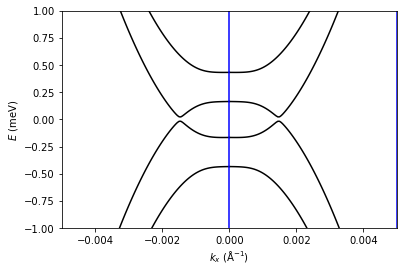

In [9]:
##  -------------------- plot dispersion --------------------                                                                                                                                                                                                                                                      
PH = np.zeros_like(E)    # particle-hole character                                                                                                                                         
for i, e in enumerate(E):    
    ind   = np.argsort(e)
    E[i]  = e[ind]
    V[i]  = V[i,:,ind].T
    PH[i] = np.diag(np.dot(V[i].T.conj(),P_op.dot(V[i]))).real                                                                                                   

plt.figure()                                                                                                                                                                                                                                                                           
plt.plot(dist,1e3*E,'k-')
plt.plot(-dist,1e3*E,'k-') 
for x in dist[::nsteps]:                                                                                                                                           
    plt.axvline(x,color='b')                                                                                                                                       
plt.xlim([-dist[-1],dist[-1]])                                                                                                                                       
plt.ylim([-1,1])                                                                                                                                                                                                                                                                                                  
plt.xlabel(r'$k_x\ (\mathrm{\AA}^{-1})$')                                                                                                                          
plt.ylabel(r'$E\ \mathrm{(meV)}$')  
plt.show()